<a href="https://colab.research.google.com/github/ClaraVilladiego/Actividad-1/blob/main/Prediciendo_futuras_ventas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prediccion de futuras ventas (predict future sales)
En este cuaderno se realiza una exploración de analisis de datos y modelamiento predictivo de las futuras ventas mensuales para la compañia 1C Company. El objetivo principal es predecir las ventas totales de cada producto y tienda para el proximo mes.

**¿Quién es 1C Company?**

Esta compañia rusa se dedica a manufacturar, licenciar, vender y dar soporte a software, videojuegos y servicios adicionales. Varios de sus productos se enfocan en soluciones para el negocio incluyendo soluciones ERP, contabilidad, financias y gerencia. Tiene una posición lider en el mercado de software comercial ruso.


# Importando librerias y datos

In [1]:
# Cargando librerias
import gc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import datetime

from sklearn.preprocessing import LabelEncoder

from itertools import product
from xgboost import XGBRegressor
from xgboost import plot_importance


In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '.'
!chmod 600 ./kaggle.json
!kaggle competitions download -c competitive-data-science-predict-future-sales
!unzip "competitive-data-science-predict-future-sales.zip"

 93% 14.0M/15.1M [00:00<00:00, 38.3MB/s]
100% 15.1M/15.1M [00:00<00:00, 43.4MB/s]
Archive:  competitive-data-science-predict-future-sales.zip
  inflating: item_categories.csv     
  inflating: items.csv               
  inflating: sales_train.csv         
  inflating: sample_submission.csv   
  inflating: shops.csv               
  inflating: test.csv                


In [ ]:
# Cargando Datos
route = "/content/"
categorias = pd.read_csv(route + "item_categories.csv")
items = pd.read_csv(route + "items.csv")
ventas = pd.read_csv(route + "sales_train.csv")
tiendas = pd.read_csv(route + "shops.csv")
test = pd.read_csv(route + "test.csv")

datos = {"categorias": categorias,
         "items": items,
         "ventas": ventas,
         "tiendas": tiendas,
         "test": test}

# Descripcion de los datos

In [ ]:
# Revisando informacion basica de los datos
for nombre, dato in datos.items():
    print("Informacion sobre: " + nombre)
    dato.info()
    print("_"*50)
    print(" ")
    dato.isnull().sum()
    print("_"*50)
    print(" ")

Informacion sobre: categorias
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   item_category_name  84 non-null     object
 1   item_category_id    84 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB
__________________________________________________
 
__________________________________________________
 
Informacion sobre: items
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   item_name         22170 non-null  object
 1   item_id           22170 non-null  int64 
 2   item_category_id  22170 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 519.7+ KB
__________________________________________________
 
__________________________________________________
 

La gran mayoria de la información se encuentra en el .csv de **ventas** con 2935848 datos. Este conjunto de datos contiene las ventas diarias generadas desde Enero 2013 hasta Octubre 2015. Este set de datos presenta 6 variables:

*date:* fecha en formato dd/mm/yyyy.  	<br>
*date_block_num:* numeracion consecutiva por mes, donde Enero 2013 es 0, Febrero 2013 es 1 y asi hasta Octubre 2015 que es 33. <br>
*shop_id*: Identificador unico de la tienda. <br>
*item_id*: Identificador unico del item. <br>
*item_price*: Precio actual del item. <br>
*item_cnt_day*: Numero de Unidades Vendidas. Variable que se busca predecir (en tamaño por meses). <br>

El segundo conjunto de datos mas grande es **test** que contiene la informacion de las ventas que se buscan predecir para Noviembre 2015. Tiene 214199 datos y presenta 3 variables.

*ID*: tuple que representa la tienda y el item. <br>
*shop_id*: Identificador unico de la tienda. <br>
*item_id*: Identificador unico del item. <br>

El resto de los datos son variables auxiliares que sirven para identificar los items, categorias y tiendas.

No se observan datos faltantes

# Exploracion inicial de los datos
# Ventas



In [ ]:
# Transformando a formato fecha
ventas["date"] = ventas.date.apply(lambda x:datetime.datetime.strptime(x, '%d.%m.%Y'))
# Creando variables de mes y dia para considerar en el modelo
ventas["month"] = ventas["date"].dt.month
ventas["days"] = ventas["date"].dt.day

In [ ]:
ventas.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,date_block_num,shop_id,item_id,item_price,item_cnt_day,month,days
count,2935849.00000,2935849.00000,2935849.00000,2935849.00000,2935849.00000,2935849.00000,2935849.00000
mean,14.56991,33.00173,10197.22706,890.85323,1.24264,6.24772,15.85267
std,9.42299,16.22697,6324.29735,1729.79963,2.61883,3.53622,8.92348
min,0.00000,0.00000,0.00000,-1.00000,-22.00000,1.00000,1.00000
25%,7.00000,22.00000,4476.00000,249.00000,1.00000,3.00000,8.00000
50%,14.00000,31.00000,9343.00000,399.00000,1.00000,6.00000,16.00000
75%,23.00000,47.00000,15684.00000,999.00000,1.00000,9.00000,24.00000
max,33.00000,59.00000,22169.00000,307980.00000,2169.00000,12.00000,31.00000


Como se puede observar, hay valores extraños en el precio y el numero de items vendidos por dia. Al analizar el precio se observa que hay items con valores negativos y items con precios exorbitantes. En el conteo por day vemos que hay un numero negativo de items vendidos, lo cual no tiene mucho sentido, asi como uno o mas items con gran cantidad de ventas por dia (2169).

In [ ]:
# Corrigiendo valores negativos - Precio
neg_price = ventas.loc[ventas["item_price"] < 0]
mean_price_neg = ventas.loc[(ventas["shop_id"].isin(neg_price["shop_id"])) &
                            (ventas["item_id"].isin(neg_price["item_id"])),"item_price"].mean()
ventas.loc[ventas["item_price"] < 0, "item_price"] = mean_price_neg

In [ ]:
# Corrigiendo valores negativos - Numero de items
neg_items_cnt = ventas.loc[ventas["item_cnt_day"] < 0]
neg_items_cnt.shop_id.value_counts()

31    451
12    430
54    356
25    316
57    314
6     261
42    251
28    216
19    211
43    211
56    195
47    193
58    173
44    165
53    163
38    162
27    157
37    154
29    151
52    143
16    139
59    137
30    135
26    134
18    132
50    130
15    130
35    128
21    125
4     124
14    120
3     119
24    103
45    103
46    102
7      99
22     97
48     89
5      85
41     82
2      80
17     80
49     42
39     37
32     34
34     25
33     22
23     17
40     13
9       8
8       6
36      3
55      2
20      1
Name: shop_id, dtype: int64

Se identifica cuantos registros por tienda presentan errores sobre el numero de productos vendidos. Debido a que no tiene sentido contar con un numero negativo de ventas, se asume que es un error de sistema y se eliminan estos registros del analisis.

In [ ]:
ventas = ventas.loc[ventas["item_cnt_day"] >= 0]

Se analiza la distribucion del precio por item y el numero de items vendidos por dia mediante diagramas de box.

<Axes: ylabel='item_cnt_day'>

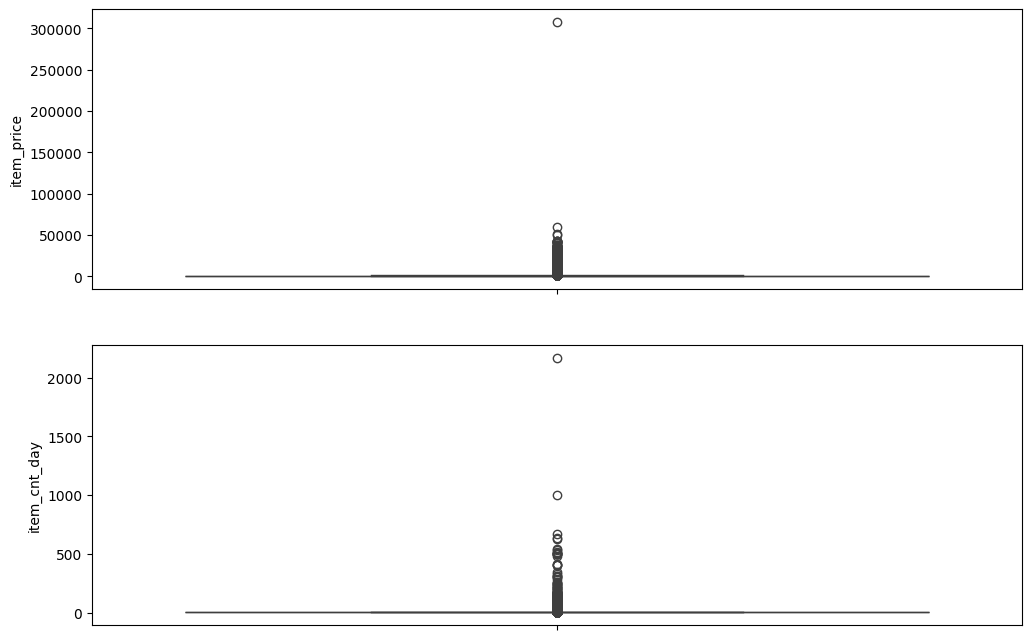

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(12,8))
sns.boxplot(ventas["item_price"], ax=ax[0])
sns.boxplot(ventas["item_cnt_day"], ax=ax[1])

In [ ]:
ventas.loc[ventas["item_price"] > 50000]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,month,days
885138,2013-09-17,8,12,11365,59200.0,1.0,9,17
1163158,2013-12-13,11,12,6066,307980.0,1.0,12,13
1488135,2014-03-20,14,25,13199,50999.0,1.0,3,20


In [ ]:
ventas.loc[ventas["item_cnt_day"] > 500]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,month,days
1573253,2014-04-22,15,27,8057,1200.000000,502.0,4,22
1708207,2014-06-28,17,25,20949,5.000000,501.0,6,28
2048518,2014-10-02,21,12,9242,1500.000000,512.0,10,2
2067669,2014-10-09,21,55,19437,899.000000,508.0,10,9
2326930,2015-01-15,24,12,20949,4.000000,1000.0,1,15
2608040,2015-04-14,27,12,3731,1904.548077,624.0,4,14
2626181,2015-05-19,28,12,11373,155.192950,539.0,5,19
2851073,2015-09-29,32,55,9249,1500.000000,533.0,9,29
2851091,2015-09-30,32,55,9249,1702.825746,637.0,9,30
2864235,2015-09-30,32,12,9248,1692.526158,669.0,9,30


* El 75% de los precios se concentra en valores menores a 999, los precios mas extremos se observan en muy baja cantidad. Hay un item con un precio por encima de los 300K y 2 por encima de los 50K.  
* El 75% de los items vendidos es de una unidad por dia, se observan solo dos articulos con valores por encima de las 1000 unidades vendidas por dia y solo 12 articulos con valores encima de las 500 unidades.
* Con base en lo anterior se opta por filtrar los items con precios menores a 50K y cantidad de items vendida por debajo de las 500 unidades por dia.

In [ ]:
ventas = ventas.loc[ventas["item_price"] <= 50000]
ventas = ventas.loc[ventas["item_cnt_day"] <= 500]
print("Conjunto de datos de ventas corregidos")
ventas.describe().apply(lambda s: s.apply('{0:.5f}'.format))

Conjunto de datos de ventas corregidos


,date_block_num,shop_id,item_id,item_price,item_cnt_day,month,days
count,2928478.00000,2928478.00000,2928478.00000,2928478.00000,2928478.00000,2928478.00000,2928478.00000
mean,14.56972,33.00300,10200.27276,889.32481,1.24537,6.24840,15.85407
std,9.42294,16.22541,6324.40172,1717.56887,1.96596,3.53592,8.92342
min,0.00000,0.00000,0.00000,0.07000,1.00000,1.00000,1.00000
25%,7.00000,22.00000,4477.00000,249.00000,1.00000,3.00000,8.00000
50%,14.00000,31.00000,9355.00000,399.00000,1.00000,6.00000,16.00000
75%,23.00000,47.00000,15691.00000,999.00000,1.00000,9.00000,24.00000
max,33.00000,59.00000,22169.00000,49782.00000,500.00000,12.00000,31.00000


# Analisis exploratorio de los datos

¿Cúantos items fueron vendidos por mes?

<Axes: xlabel='date', ylabel='item_cnt_day'>

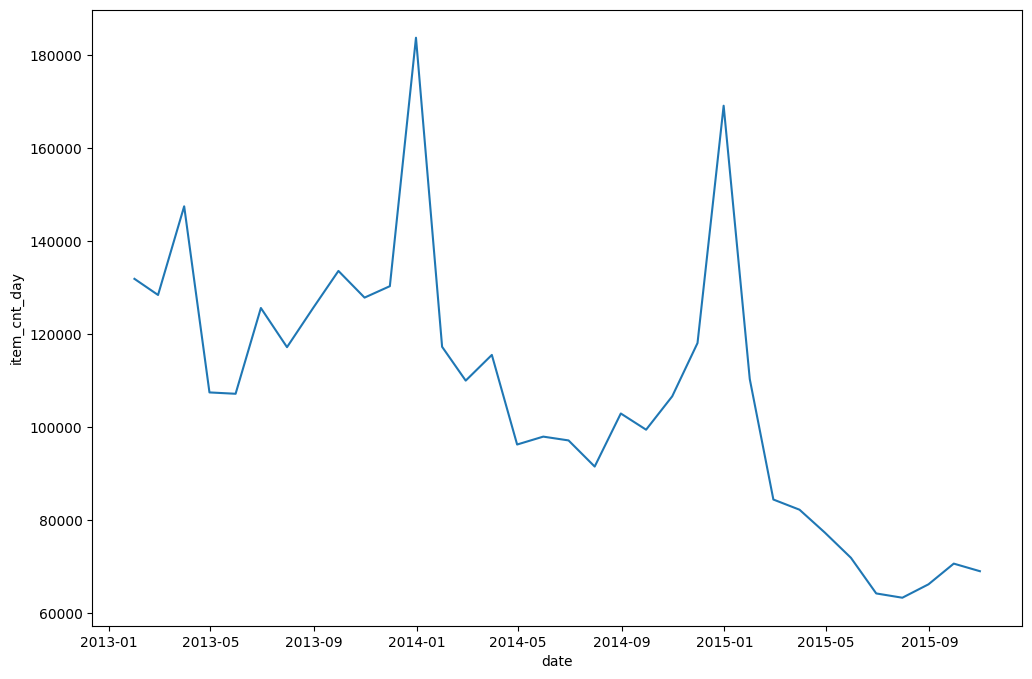

In [ ]:
ventas_tiempo = ventas.copy()
ventas_tiempo = ventas_tiempo.set_index('date')
total_items_por_mes = ventas_tiempo.item_cnt_day.resample('M').sum()

fig, ax = plt.subplots(figsize=(12,8))
sns.lineplot(data=total_items_por_mes, ax=ax)

* Picos de ventas en Noviembre. - seasonality
* Incremento de ventas para el mes de Junio. - Julio
* Numero de items vendidos decrece con el tiempo.

¿Cuál tienda tiene un mayor volumen de ventas?

<Axes: xlabel='shop_id', ylabel='item_cnt_day'>

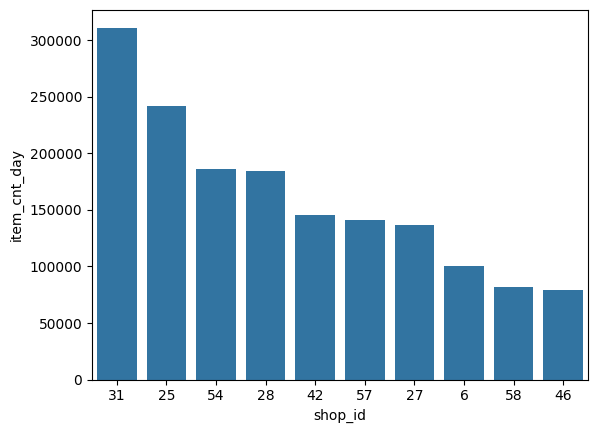

In [ ]:
ventas_tienda = ventas.groupby(["shop_id"])["item_cnt_day"].sum()
ventas_tienda.sort_values(ascending=False, inplace=True)
ventas_tienda = ventas_tienda[0:10].reset_index()
sns.barplot(y="item_cnt_day", x="shop_id", data=ventas_tienda, order=ventas_tienda.sort_values('item_cnt_day', ascending=False)["shop_id"])

La tienda con mayor volumen de ventas total es la 31, seguida de la 25 y la 54. Examinando las tiendas se observa que 4 de las tiendas con mayor volumen de ventas quedan en Moscu. Ademas, la gran mayoria de las ventas se obtienen en centro comerciales (ТЦ o ТРК). A pesar de ser un negocio de software, gran parte de las ventas no se realiza online, se realiza por medios tradicionales.

¿Cuál es el item mas popular en cada tienda?

In [ ]:
ventas_tienda_item = ventas.groupby(["shop_id","item_id"])["item_cnt_day"].sum().reset_index()

for tienda in ventas_tienda_item.shop_id.unique():
    agg_ventas_tienda = ventas_tienda_item.loc[ventas_tienda_item["shop_id"] == tienda]
    item_tienda_sort = agg_ventas_tienda.sort_values(["item_cnt_day"], ascending=False)
    print(item_tienda_sort.max())


shop_id             0.0
item_id         22160.0
item_cnt_day       79.0
dtype: float64
shop_id             1.0
item_id         22154.0
item_cnt_day       62.0
dtype: float64
shop_id             2.0
item_id         22168.0
item_cnt_day     1319.0
dtype: float64
shop_id             3.0
item_id         22167.0
item_cnt_day     1137.0
dtype: float64
shop_id             4.0
item_id         22167.0
item_cnt_day     2465.0
dtype: float64
shop_id             5.0
item_id         22167.0
item_cnt_day     2163.0
dtype: float64
shop_id             6.0
item_id         22167.0
item_cnt_day     3551.0
dtype: float64
shop_id             7.0
item_id         22167.0
item_cnt_day     3321.0
dtype: float64
shop_id             8.0
item_id         22151.0
item_cnt_day       31.0
dtype: float64
shop_id             9.0
item_id         22102.0
item_cnt_day      305.0
dtype: float64
shop_id            10.0
item_id         22167.0
item_cnt_day     1413.0
dtype: float64
shop_id            11.0
item_id         221

In [ ]:
items.iloc[22167].item_name

'Язык запросов 1С:Предприятия 8 (+CD). Хрусталева Е.Ю.'

Se observa que el item 22167 (Язык запросов 1С:Предприятия 8 (+CD). Хрусталева Е.Ю.') es bastante popular en muchas de las tiendas. Este item es un libro de consulta de 1C Company. Para todos los casos, los items en el catalogo presentan un alto valor de id, seria necesario revisar a que categoria pertenecen estos articulos.  

¿Cuál tienda produce mayores ganancias?

<Axes: xlabel='shop_id', ylabel='revenue'>

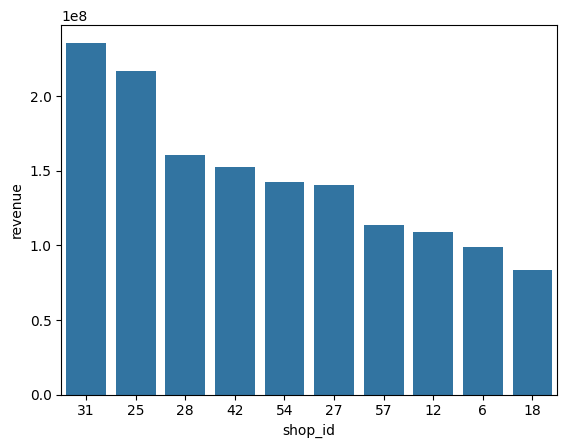

In [ ]:
ventas["revenue"] = ventas["item_cnt_day"] * ventas["item_price"]
ventas_tienda = ventas.groupby(["shop_id"])["revenue"].sum()
ventas_tienda.sort_values(ascending=False, inplace=True)
ventas_tienda = ventas_tienda[0:10].reset_index()
sns.barplot(y="revenue", x="shop_id", data=ventas_tienda, order=ventas_tienda.sort_values('revenue', ascending=False)["shop_id"])

Como se esperaba, las tiendas 31 y 25 con el mayor volumen de ventas son las tiendas mas rentables de todas. Sin embargo algunas tiendas con menor volumen de ventas son mas rentables que otras con mayor volumen. Por ejemplo la tienda 28 es mas rentable que la tienda 57 a pesar que la tienda 57 vende mas productos. Incluso las tiendas 6 y 12 que no aparecen en el top 10 de mayor volumen de ventas si aparecen en el Top 10 de tiendas rentables. Seria interesante revisar que tipo de productos se venden en esas tiendas.

El trend de tiempo muestra picos claramente definidos para los meses de Noviembre 2013 y 2014, asi que resulta de interes saber que tiendas y items se venden durante estos meses en particular.

<Axes: xlabel='shop_id', ylabel='item_cnt_day'>

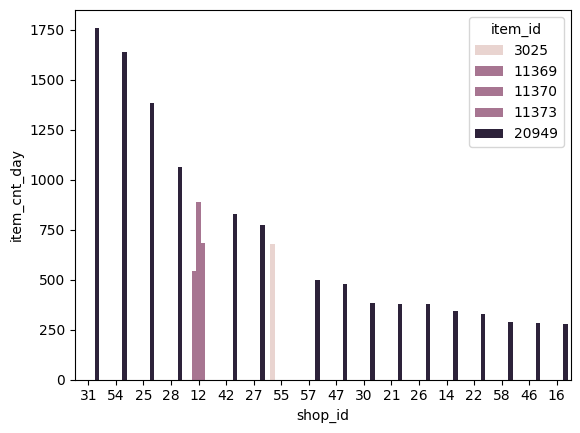

In [ ]:
nov_ventas = ventas.loc[ventas["month"] == 11]
group_nov_ventas = nov_ventas.groupby(["shop_id", "item_id"])["item_cnt_day"].sum().reset_index()
top20_nov_items = group_nov_ventas.sort_values(["item_cnt_day"], ascending=False)[0:20]

sns.barplot(y="item_cnt_day", x="shop_id", data=top20_nov_items,
            order=top20_nov_items.sort_values('item_cnt_day', ascending=False)["shop_id"],
            hue="item_id")

In [ ]:
items.iloc[20949].item_name

'Фирменный пакет майка 1С Интерес белый (34*42) 45 мкм'

Analizando el top 20 de los productos mas vendidos en los meses de Noviembre, se observa que el item 20949 (Фирменный пакет майка 1С Интерес белый (34*42*) 45 мкм) es el mas popular es varias tiendas. Este producto es una camisa con el logo de 1C company. Esto lleva a sospechar que hay un evento o festividad que realiza la compañia para promocionarse durante este mes, que incluye ofertas por este producto.    

# Limpieza de los datos y Feature Engineering

# Tiendas

Despues de traducir los nombres de las tiendas mediante DeepL https://www.deepl.com/translator, se observan tres puntos importantes:

1. Muchas tiendas empiezan con el nombre de la cuidad.
2. Algunas tiendas tienen el tipo de local (Centro Comercial, tienda, etc.)
3. Hay nombres de tienda repetidos.

In [ ]:
list_tiendas = tiendas.shop_name.str.split(" ")
tiendas["city"] = [tienda[0] for tienda in list_tiendas]
tiendas["shop_type"] = [tienda[1] for tienda in list_tiendas]

In [ ]:
#Corrigiendo los nombres de ciudades
tiendas.loc[tiendas["city"] == "!Якутск", "city"] = "Якутск"
tiendas.loc[tiendas["city"] == "Интернет-магазин", "city"] = "NA"
tiendas['city_id'] = LabelEncoder().fit_transform(tiendas['city'])
#Corrigiendo los tipos de tiendas
tiendas.loc[tiendas["shop_type"] == "Орджоникидзе,", "shop_type"] = "доме"
tiendas.loc[tiendas["shop_type"] == "(Плехановская,", "shop_type"] = "доме"
tiendas.loc[tiendas["shop_type"] == '"Распродажа"', "shop_type"] = "МТРЦ"
tiendas.loc[tiendas["shop_type"] == 'Посад', "shop_type"] = "Интернет-магазин"
tiendas.loc[tiendas["shop_type"] == 'ЧС', "shop_type"] = "Интернет-магазин"
tiendas['shop_type_id'] = LabelEncoder().fit_transform(tiendas['shop_type'])
tiendas

,shop_name,shop_id,city,shop_type,city_id,shop_type_id
0,"!Якутск Орджоникидзе, 56 фран",0,Якутск,доме,29,8
1,"!Якутск ТЦ ""Центральный"" фран",1,Якутск,ТЦ,29,6
2,"Адыгея ТЦ ""Мега""",2,Адыгея,ТЦ,1,6
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха,ТРК,2,4
4,"Волжский ТЦ ""Волга Молл""",4,Волжский,ТЦ,3,6
5,"Вологда ТРЦ ""Мармелад""",5,Вологда,ТРЦ,4,5
6,"Воронеж (Плехановская, 13)",6,Воронеж,доме,5,8
7,"Воронеж ТРЦ ""Максимир""",7,Воронеж,ТРЦ,5,5
8,"Воронеж ТРЦ Сити-Парк ""Град""",8,Воронеж,ТРЦ,5,5
9,Выездная Торговля,9,Выездная,Торговля,6,7


In [ ]:
#Corrigiendo duplicacion de nombre de tiendas.
# 0 - !Якутск Орджоникидзе, 56 фран
# 57 - Якутск Орджоникидзе, 56
ventas.loc[ventas.shop_id == 57, "shop_id"] = 0
test.loc[test.shop_id == 57, "shop_id"] = 0

# 1 - !Якутск ТЦ "Центральный" фран
# 58 - Якутск ТЦ "Центральный"
ventas.loc[ventas.shop_id == 58, "shop_id"] = 1
test.loc[test.shop_id == 58, "shop_id"] = 1

# 39 - РостовНаДону ТРК "Мегацентр Горизонт"
# 40 - РостовНаДону ТРК "Мегацентр Горизонт" Островной
ventas.loc[ventas.shop_id == 40, "shop_id"] = 39
test.loc[test.shop_id == 40, "shop_id"] = 39

# 10 - Жуковский ул. Чкалова 39м?
# 11 - Жуковский ул. Чкалова 39м²
ventas.loc[ventas.shop_id == 11, "shop_id"] = 10
test.loc[test.shop_id == 11, "shop_id"] = 10
tiendas.drop([57, 58, 40, 11])

,shop_name,shop_id,city,shop_type,city_id,shop_type_id
0,"!Якутск Орджоникидзе, 56 фран",0,Якутск,доме,29,8
1,"!Якутск ТЦ ""Центральный"" фран",1,Якутск,ТЦ,29,6
2,"Адыгея ТЦ ""Мега""",2,Адыгея,ТЦ,1,6
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха,ТРК,2,4
4,"Волжский ТЦ ""Волга Молл""",4,Волжский,ТЦ,3,6
5,"Вологда ТРЦ ""Мармелад""",5,Вологда,ТРЦ,4,5
6,"Воронеж (Плехановская, 13)",6,Воронеж,доме,5,8
7,"Воронеж ТРЦ ""Максимир""",7,Воронеж,ТРЦ,5,5
8,"Воронеж ТРЦ Сити-Парк ""Град""",8,Воронеж,ТРЦ,5,5
9,Выездная Торговля,9,Выездная,Торговля,6,7


# Categorias

Al traducir las categorias se observa que tienen una categoria y una subcategoria. Por ejemplo Аксессуары - PS2 es Accesorios - PS2. Esto crea variables adicionales que pueden ser consideradas en el modelo.

In [ ]:
list_categorias = categorias.item_category_name.str.split(" - ")
categorias["cat"] = [cat[0] for cat in list_categorias]

subcat = []
for cat in list_categorias:
    if len(cat) > 1:
        subcat.append(cat[1])
    else:
        subcat.append("NA")

categorias["subcat"] = subcat
categorias["cat_id"] = LabelEncoder().fit_transform(categorias["cat"])
categorias["subcat_id"] = LabelEncoder().fit_transform(categorias["subcat"])
categorias.drop("item_category_name", axis=1)

,item_category_id,cat,subcat,cat_id,subcat_id
0,0,PC,Гарнитуры/Наушники,0,31
1,1,Аксессуары,PS2,1,12
2,2,Аксессуары,PS3,1,13
3,3,Аксессуары,PS4,1,14
4,4,Аксессуары,PSP,1,16
...,...,...,...,...,...
79,79,Служебные,NA,16,11
80,80,Служебные,Билеты,16,28
81,81,Чистые носители (шпиль),NA,17,11
82,82,Чистые носители (штучные),NA,18,11


# Datos de Prueba

Se analiza si todos las tiendas y todos los items en el conjunto de entrenamiento estan en los datos de prueba.

In [ ]:
tiendas_ventas = set(ventas.shop_id.unique())
tiendas_test = set(test.shop_id.unique())

print("Todas los tiendas del conjunto de prueba estan en los datos de entrenamiento?")
print(tiendas_test.issubset(tiendas_ventas))

Todas los tiendas del conjunto de prueba estan en los datos de entrenamiento?
True


In [ ]:
items_ventas = set(ventas.item_id.unique())
items_test = set(test.item_id.unique())

print("Todos los items del conjunto de prueba estan en los datos de entrenamiento?")
print(items_test.issubset(items_ventas))

print("Items que estan en el base de datos de prueba pero no los datos de entrenamiento")
print("Numero de items faltantes: " + str(len(items_test - items_ventas)))


Todos los items del conjunto de prueba estan en los datos de entrenamiento?
False
Items que estan en el base de datos de prueba pero no los datos de entrenamiento
Numero de items faltantes: 363


Hay items en los datos de prueba que no estan en los datos de entrenamiento. Debido a que no se cuenta con informacion sobre estos productos, es de esperar que la prediccion del modelo sobre la venta de estos nuevos productos sea 0.  

# Cambiar formato de los datos

Debido a que el objetivo es predecir el numero de ventas de cada tienda e item en un mes. Es necesario organizar la informacion por meses. Para ello la variable *date_block_num* es muy util ya que nos permite organizar la informacion por meses de manera ascendente.

In [ ]:
## Agrupando informacion de ventas por mes
# La columna date_block_num representa los meses de forma consecutiva
total_ventas_mes = ventas.groupby(["date_block_num","shop_id","item_id"])["item_cnt_day"].sum().reset_index()
total_ventas_mes = total_ventas_mes.fillna(0.0)
total_ventas_mes

,date_block_num,shop_id,item_id,item_cnt_day
0,0,0,32,6.0
1,0,0,33,3.0
2,0,0,35,1.0
3,0,0,43,1.0
4,0,0,51,2.0
...,...,...,...,...
1607366,33,59,22087,6.0
1607367,33,59,22088,2.0
1607368,33,59,22091,1.0
1607369,33,59,22100,1.0


No todas las tiendas venden todos los productos, por lo cual hay vacios entre los pares de tiendas-productos en este set de datos. Por otro lado, el formato de los datos de prueba muestra los mismos productos para todas las tiendas. Con el fin de mantener el mismo formato para ambos set de datos resulta mas conveniente crear un formato con todos los pares de tienda producto y colocar 0 en el numero de ventas cuando la tienda no venda ese producto.

In [ ]:
formato_ventas = []

# Generando todos los pares tienda-producto
for date_block in ventas["date_block_num"].unique():
    ventas_mes = ventas.loc[ventas["date_block_num"] == date_block]

    tiendas_unicas = ventas.loc[ventas['date_block_num'] == date_block, 'shop_id'].unique()
    items_unicos = ventas.loc[ventas['date_block_num'] == date_block, 'item_id'].unique()
    formato_ventas.append(np.array(list(product([date_block],
                                        tiendas_unicas,
                                        items_unicos)),
                                        dtype='int16'))

# Cambiando formato de lista a DataFrame
formato_ventas = pd.DataFrame(np.vstack(formato_ventas), columns=["date_block_num", "shop_id", "item_id"]).reset_index()
formato_ventas.sort_values("date_block_num",inplace=True)

#Combinando formato con ventas por mes
total_ventas = pd.merge(formato_ventas, total_ventas_mes, on=["date_block_num", "shop_id", "item_id"], how='left')
total_ventas = total_ventas.fillna(0)
total_ventas = total_ventas.drop("index", axis=1)
total_ventas["item_cnt_day"] = total_ventas["item_cnt_day"].astype("float16")



In [ ]:
# Limpiando memoria para liberar espacio
del formato_ventas
del total_ventas_mes
del ventas_tiempo
del ventas_tienda_item
del ventas_mes
del top20_nov_items
del group_nov_ventas
del item_tienda_sort
del neg_items_cnt
del total_items_por_mes
del agg_ventas_tienda
del fig, ax
gc.collect()

403

# Integrando Datos

Se combinan los set de datos de entrenamiento y prueba para poder añadir variables adicionales como Categorias, Ciudad de la Tienda, Tipo de Tienda y valores promedio al conjunto de datos, posteriormente se realiza la separacion durante el modelamiento.

In [ ]:
# Entrenamiento + Prueba
test.drop(["ID"], axis=1, inplace=True)
test["date_block_num"] = 34
total_ventas = pd.concat([total_ventas, test], ignore_index=True,
                          sort=False, keys=["date_block_num", "shop_id", "item_id"])
total_ventas.fillna(0, inplace=True)
total_ventas["date_block_num"] = total_ventas["date_block_num"].astype("int16")
total_ventas["shop_id"] = total_ventas["shop_id"].astype("int16")
total_ventas["item_id"] = total_ventas["item_id"].astype("int16")


In [ ]:
# Categoria y subcategorias de los items
items_cat = pd.merge(items,categorias,on="item_category_id", how="left")
items_cat.drop(["item_name","item_category_name", "item_category_id","cat","subcat"], axis=1, inplace=True)
total_ventas = pd.merge(total_ventas, items_cat, on="item_id", how='left')
total_ventas["cat_id"] = total_ventas["cat_id"].astype("int16")
total_ventas["subcat_id"] = total_ventas["subcat_id"].astype("int16")
del items_cat

In [ ]:
# Ciudad y tipo de tiendas
tiendas_var = tiendas.drop(["shop_name","shop_type","city"],axis=1)
total_ventas = pd.merge(total_ventas, tiendas_var, on="shop_id", how='left')
total_ventas["city_id"] = total_ventas["city_id"].astype("int16")
total_ventas["shop_type_id"] = total_ventas["shop_type_id"].astype("int16")
del tiendas_var

In [ ]:
#mes
total_ventas["month"] = total_ventas["date_block_num"] % 12 + 1

# Autocorrelacion y Retrasos

En problemas con series de tiempo es usual que se analize si la serie de datos presenta autocorrelaciones, es decir que existen correlaciones entre datos en diferentes periodos de tiempo. Por ejemplo cuando se estudia los cambios de temperatura en diferentes dias, la temperatura tiende a ser mas alta a mediodia y baja a medianoche, independiente del dia. Esto causa una correlacion entre temperaturas tomadas en horas similares.

En este caso al analizar el numero de ventas a traves del tiempo vemos que se repiten picos de venta en Noviembre y posterior descenso del numero de ventas en Enero y Febrero, asi como repuntes en Junio-Julio. Lo que nos lleva a pensar que hay autocorrelacion en los datos. Con el fin de capturar esta informacion se añaden retrasos (lags) como predictores. Para mas informacion sobre autocorrelacion y el uso de retrasos consulte el libro *Algoritmos para ciencia de datos* de Steele, Chandler y Reddy:

Steele, B., Chandler, J., & Reddy, S. (2016). Forecasting. In B. Steele, J. Chandler, & S. Reddy, Algorithms for Data Science (pp. 343-375). Missoula, MT: Springer International Publishing.

In [ ]:
# Retrasos(lags)
def lags_vars(target_df, target_cols, lags=[1,6,12]):
    std_cols = ['date_block_num','shop_id','item_id'] # columnas estandar

    for col in target_cols:
        std_cols.append(col)

    original = target_df.loc[:,std_cols]

    for lag in lags:
        for col in target_cols:
            shift = original.copy()
            colname = "lag_"+str(lag)+"_"+col
            shift.rename(columns={col: colname}, inplace=True)

        shift.loc[:,'date_block_num'] = shift.loc[:,'date_block_num'] + lag
        target_df = pd.merge(target_df, shift,
                             on=['date_block_num','shop_id','item_id'],
                             how='left')


    return target_df


In [ ]:
total_ventas = lags_vars(total_ventas, ["item_cnt_day"]).fillna(0)

# Media movil (Mobile Average)

Otra metrica muy utilizada en analisis de series es la media movil. La idea detras de esta metrica es crear una serie de promedio de diferentes subconjuntos del set de datos. Esto permite reducir el efecto de fluctuaciones cortas en el tiempo y concentrarse en patrones de mayor duracion.

En este caso se toman los promedios del numero de venta por cada mes bajo diferentes agrupaciones. En particular tomaremos 3 promedios:

* Numero de ventas por mes por cada tienda.
* Numero promedio de ventas por mes por cada articulo.
* Numero promedio de ventas por mes por cada categoria.

Adicionalmente se realiza un retraso para estas promedios para incluir este efecto en el modelo.

In [ ]:
#Funcion para generar datos agregados
def aggregate_data(data_df, target_df, cols, fun, name, target="item_cnt_day"):
    agg_values = data_df.groupby(cols)[target].apply(lambda x: fun(x)).reset_index()
    agg_values = agg_values.rename({target: name}, axis=1)
    target_df = pd.merge(target_df,agg_values, on=cols, how='left').fillna(0)
    target_df[name] = target_df[name].astype("float16")
    return target_df

In [ ]:
# Valores agregados
# Promedio de numero de ventas por mes para cada tienda
total_ventas = aggregate_data(data_df=ventas, target_df=total_ventas,
                              cols=["date_block_num", "shop_id"],
                              fun=np.mean,
                              name="mean_shop_block")
# Promedio de numero de ventas por mes para cada item
total_ventas = aggregate_data(data_df=ventas, target_df=total_ventas,
                              cols=["date_block_num", "item_id"],
                              fun=np.mean,
                              name="mean_item_block")
# Promedio de numero de ventas por mes por cada categoria
items_cat = pd.merge(items,categorias,on="item_category_id", how="left")
items_cat.drop(["item_name","item_category_name", "item_category_id","cat","subcat"], axis=1, inplace=True)
ventas_cat = pd.merge(ventas, items_cat, on="item_id", how="left")

total_ventas = aggregate_data(data_df=ventas_cat, target_df=total_ventas,
                              cols=["date_block_num", "cat_id"],
                              fun=np.mean,
                              name="mean_cat_block")

total_ventas = aggregate_data(data_df=ventas, target_df=total_ventas,
                              target="item_price",
                              cols=["date_block_num", "item_id"],
                              fun=np.mean,
                              name="mean_item_price")

total_ventas

,date_block_num,shop_id,item_id,item_cnt_day,cat_id,subcat_id,city_id,shop_type_id,month,lag_1_item_cnt_day,lag_6_item_cnt_day,lag_12_item_cnt_day,mean_shop_block,mean_item_block,mean_cat_block,mean_item_price
0,0,59,22154,1.0,11,1,30,6,1,0.0,0.0,0.0,1.101562,1.0,1.125977,999.0
1,0,35,2565,0.0,13,5,15,5,1,0.0,0.0,0.0,1.079102,1.0,1.024414,549.0
2,0,35,2564,0.0,13,40,15,5,1,0.0,0.0,0.0,1.079102,1.0,1.024414,327.5
3,0,35,2555,0.0,13,5,15,5,1,0.0,0.0,0.0,1.079102,1.0,1.024414,1099.0
4,0,35,2554,0.0,13,29,15,5,1,0.0,0.0,0.0,1.079102,1.0,1.024414,1709.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11026963,34,45,18454,0.0,13,4,20,6,11,1.0,0.0,0.0,0.000000,0.0,0.000000,0.0
11026964,34,45,16188,0.0,14,42,20,6,11,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
11026965,34,45,15757,0.0,13,4,20,6,11,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
11026966,34,45,19648,0.0,11,6,20,6,11,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0


In [ ]:
total_ventas = lags_vars(total_ventas, ["mean_shop_block"]).fillna(0)
total_ventas = lags_vars(total_ventas, ["mean_item_block"]).fillna(0)
total_ventas = lags_vars(total_ventas, ["mean_cat_block"]).fillna(0)
total_ventas = lags_vars(total_ventas, ["mean_item_price"]).fillna(0)

In [ ]:
total_ventas.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_day', 'cat_id',
       'subcat_id', 'city_id', 'shop_type_id', 'month', 'lag_1_item_cnt_day',
       'lag_6_item_cnt_day', 'lag_12_item_cnt_day', 'mean_shop_block',
       'mean_item_block', 'mean_cat_block', 'mean_item_price',
       'lag_1_mean_shop_block', 'lag_6_mean_shop_block',
       'lag_12_mean_shop_block', 'lag_1_mean_item_block',
       'lag_6_mean_item_block', 'lag_12_mean_item_block',
       'lag_1_mean_cat_block', 'lag_6_mean_cat_block', 'lag_12_mean_cat_block',
       'lag_1_mean_item_price', 'lag_6_mean_item_price',
       'lag_12_mean_item_price'],
      dtype='object')

# Guardar datos final

Se guarda los datos finales como archivo .pkl para poder cargar posteriormente en el modelo. Debido a que el cuaderno esta en Kaggle, la ruta donde se encuentra el archivo es */kaggle/working*. Esta carpeta es temporal y solo aplica cuando se corre el cuaderno. Posteriomente es borrada automaticamente en el servidor

In [ ]:
total_ventas.to_pickle('datos_final.pkl')

In [ ]:
del ventas
del items
del categorias
del tiendas
del dato
del total_ventas
del ventas_cat
del aggregate_data
del neg_price

In [ ]:
%whos

Variable          Type         Data/Info
----------------------------------------
LabelEncoder      type         <class 'sklearn.preproces<...>ing._label.LabelEncoder'>
XGBRegressor      type         <class 'xgboost.sklearn.XGBRegressor'>
cat               list         n=1
date_block        int64        33
datetime          module       <module 'datetime' from '<...>/python3.10/datetime.py'>
datos             dict         n=5
gc                module       <module 'gc' (built-in)>
items_cat         DataFrame           item_id  cat_id  s<...>n[22170 rows x 3 columns]
items_test        set          {30, 31, 32, 33, 38, 42, <...>163, 22164, 22166, 22167}
items_unicos      ndarray      5411: 5411 elems, type `int64`, 43288 bytes
items_ventas      set          {0, 1, 2, 3, 4, 5, 6, 7, <...>166, 22167, 22168, 22169}
lags_vars         function     <function lags_vars at 0x7e8f56468670>
list_categorias   Series       0        [PC, Гарнитуры/Н<...>Length: 84, dtype: object
list_tiendas      Ser

# Modelamiento

Usaremos el modelo de Gradient Boosting para predecir el numero de productos vendidos.

In [ ]:
final_data = pd.read_pickle('datos_final.pkl')

In [ ]:
train_set = final_data.loc[final_data["date_block_num"] < 33]
x_train = train_set.drop('item_cnt_day', axis=1)
y_train = train_set['item_cnt_day']

val_set = final_data.loc[final_data["date_block_num"] == 33]
x_val = val_set.drop('item_cnt_day', axis=1)
y_val = val_set['item_cnt_day']

test_set = final_data.loc[final_data["date_block_num"] == 34]
x_test = test_set.drop('item_cnt_day', axis=1)
y_test = test_set['item_cnt_day']

del train_set
del val_set
del test_set

In [ ]:
model = XGBRegressor(max_depth=10, n_estimators=1000, min_child_weight=100,
                     colsample_bytree=0.8, subsample=1, eta=0.2)

model.fit(x_train, y_train, eval_metric="rmse",
          eval_set=[(x_train, y_train), (x_val, y_val)],
          verbose=True,
          early_stopping_rounds = 20)


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:2.91486	validation_1-rmse:2.40888
[1]	validation_0-rmse:2.70382	validation_1-rmse:2.24213
[2]	validation_0-rmse:2.51137	validation_1-rmse:2.17362
[3]	validation_0-rmse:2.36968	validation_1-rmse:2.11304
[4]	validation_0-rmse:2.26535	validation_1-rmse:2.07741
[5]	validation_0-rmse:2.20670	validation_1-rmse:2.02637
[6]	validation_0-rmse:2.14069	validation_1-rmse:2.01403
[7]	validation_0-rmse:2.08340	validation_1-rmse:1.98188
[8]	validation_0-rmse:2.03303	validation_1-rmse:1.96499
[9]	validation_0-rmse:2.00004	validation_1-rmse:1.96379
[10]	validation_0-rmse:1.95686	validation_1-rmse:1.96284
[11]	validation_0-rmse:1.92867	validation_1-rmse:1.94826
[12]	validation_0-rmse:1.91357	validation_1-rmse:1.95023
[13]	validation_0-rmse:1.89430	validation_1-rmse:1.94979
[14]	validation_0-rmse:1.87708	validation_1-rmse:1.95090
[15]	validation_0-rmse:1.85842	validation_1-rmse:1.94305
[16]	validation_0-rmse:1.84356	validation_1-rmse:1.93879
[17]	validation_0-rmse:1.82952	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.2, eval_metric=None,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=None, min_child_weight=100, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
# Se usa el modelo para predecir el numero de ventas
y_test = model.predict(x_test).clip(0, 20)

final = pd.DataFrame({"ID": test.index, "item_cnt_month": y_test})

final.to_csv('gb_results.csv', index=False)